# Exploratory Data Analysis - Distribution of Semantic and Non Semantic top rationales
> Prototyping B: Code Completion

This notebook presents boxplots for each identified concept, highlighting both the least and most frequent occurrences. These concepts are grouped into semantically meaningful and non-meaningful categories (level_2). 

*Notebook Structure*
- Notebook parameters
- Source Code
    - Imports
    - Frequency Dataframes
    - Data Loading
    - Statistics
    - Calculate statistics and frequencies
- Experiment [1.2.1]
- Experiment [1.2.2]

*General Instructions*
* Collapse cells by tittle to improve the navigation
* Before running the experiments, it is required to have global_taxonomy_results for each dataset. global_taxonomy_results contains a the aggregations of rationales by level_1 taxonomomy. 
* Read description on each experiment for further instructions

In [13]:
def param_default():
    return {
        'model': 'codeparrot',
        'modality' : 'sc',
        'datasets' : {
            'SG_BD' : 'code_completion_random_cut_5k_30_512_tokens', 
            'DC_SG_BD' : 'code_completion_docstring_random_cut_3.8k_30_150_tokens', 
            'DC_SG' : 'code_completion_docstring_signature_3.8k_30_150_tokens', 
            'DC': 'code_completion_docstring_5k_30_150_tokens'
        },
        ######## INPUT
        'global_ast_results': '/workspaces/code-rationales/data/global_ast_results',
        'grouping_results': '/workspaces/code-rationales/data/experiments/grouping_results', 
        'quantitative_results' : '/workspaces/code-rationales/data/experiments/quantitative_results',
        ######## OUTPUT
        'rationales_distributions': '/workspaces/code-rationales/data/experiments/rationales_distributions',
        'num_experiments': 30,
        'num_samples': 100,
        'bootstrapping_size' : 'none'
    }
    
params = param_default()

## Source Code

In [14]:
import json
import pandas as pd
import numpy as np
import math
from statistics import NormalDist
from venn import venn

import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


pd.options.display.float_format = '{:.2f}'.format

In [15]:
from code_rationales.taxonomies import *
import os.path

### Statistic Treatments

In [16]:
def bootstrapping( np_data, np_func, size ):
    """Create a bootstrap sample given data and a function
    For instance, a bootstrap sample of means, or mediands. 
    The bootstrap replicates are a long as the original size
    we can choose any observation more than once (resampling with replacement:np.random.choice)
    """
    
    #Cleaning NaNs
    #np_data_clean = np_data[ np.logical_not( np.isnan(np_data) ) ] 
    
    #The size of the bootstrap replicate is as big as size
    #Creating the boostrap replicates as long as the orignal data size
    #This strategy might work as imputation 
    bootstrap_repl = [ np_func( np.random.choice( np_data, size=len(np_data) ) ) for i in range( size ) ]
    
    #logging.info("Covariate: " + cov) #Empirical Mean
    #logging.info("Empirical Mean: " + str(np.mean(np_data_clean))) #Empirical Mean
    #logging.info("Bootstrapped Mean: " + str( np.mean(bootstrap_repl) ) ) #Bootstrapped Mean
    
    return np.array( bootstrap_repl )

### Data Loading

In [17]:
get_experiment_path =  lambda results_folder, dataset, exp: results_folder + '/' + dataset + '_exp_' + str(exp) +'.txt'

In [18]:
def load_ast_rationales_results(dataset_id: str) :
    experiment_paths = [get_experiment_path(params['global_ast_results'] + '/' + params['model'] + '/' + params['modality'], params['datasets'][dataset_id], exp) for exp in range(params['num_experiments'])]
    experiment_results = []
    for experiment_path in experiment_paths:
        with open(experiment_path, 'r') as file:
            experiment_results.append(json.loads(file.read()))
    return experiment_results

In [19]:
def load_rationales_results(dataset_id: str, level: str) :
    file_path = params['grouping_results'] + '/' + params['model'] + '/' + params['modality'] + '/' + params['datasets'][dataset_id] + '_' + level + '.json'
    with open(file_path, 'r') as file:
        return json.loads(file.read())

### Data Processing

In [20]:
def flat_rationales_probabilities(rationales_results):
    rational_distributions = {}
    for experiment_result in rationales_results:
        experiments_rationales_values = {rational_key: [] for target_values in experiment_result.values() for rational_key in target_values.keys()}
        [experiments_rationales_values[rational_key].extend(rational_values) for target_values in experiment_result.values() for rational_key, rational_values in target_values.items()]
        for key, values in experiments_rationales_values.items(): rational_distributions.setdefault(key, []).extend(values)
    #for rational_key in rational_distributions.keys(): rational_distributions[rational_key] = bootstrapping(rational_distributions[rational_key], np.mean, params['bootstrapping_size']) ## to reduce dimentionality
    return rational_distributions

In [21]:
def get_rationales_distribution(dataset_id: str, level: str, experiments: int):
    rationales_results = load_ast_rationales_results(dataset_id)[:experiments] if level == 'level_0' else load_rationales_results(dataset_id, level)[:experiments]
    dataset_rationales_values = flat_rationales_probabilities(rationales_results)
    return dataset_rationales_values

In [22]:
def create_df_rationales_distributions(level, exp):
    file_path = params['rationales_distributions'] + '/' + params['model'] + '/' + params['modality'] + '/' + 'by_category_' + level + '_exp_' + str(exp) + '_bootstrapping_' + str(params['bootstrapping_size']) + '.csv'
    if os.path.isfile(file_path):
          plot_data = pd.read_csv(file_path, index_col=[0])
          return plot_data
    rationales_distributions = {key: {} for key in params['datasets'].keys()}
    for dataset_id in params['datasets'].keys(): rationales_distributions[dataset_id] = get_rationales_distribution(dataset_id, level, exp)
    plot_df = pd.DataFrame(
    [(dataset_id, category, value) for dataset_id, categories in rationales_distributions.items() for category, values in categories.items() for value in values],
    columns=['dataset_id', 'rational_category', 'rational_value'])
    plot_df.to_csv(file_path)
    return plot_df

## Experiment [1.2.1]
**Level 1 rationales distribution box plots by frequency**

In [23]:
frequencies_df = pd.read_csv(params['quantitative_results'] + '/' + params['model'] + '/' + params['modality']  + '/' + params['datasets']['DC'] + '_frequencies_dataset' + '.csv')

In [24]:
df_rationales_distributions_level_1 = create_df_rationales_distributions('level_1', params['num_experiments'])

/usr/local/lib/python3.8/dist-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [26]:
top_most_frequent = set()
for dataset_id in params['datasets'].keys():
    top_most_frequent.update(frequencies_df[frequencies_df['dataset_id'] == dataset_id].nlargest(10, 'total')['category'].tolist())
top_most_frequent = list(top_most_frequent)
top_most_frequent

['errors',
 'excluded',
 'unknown',
 'nl_noun',
 'punctuation',
 'identifier',
 'expression',
 'indentation',
 'structural',
 'statements']

In [27]:
pd.set_option('display.float_format', lambda x: '%7f' % x)

In [29]:
fig, axes = plt.subplots(nrows=len(top_most_frequent)*2//2, ncols=2, figsize=(20, 2.5*(len(top_most_frequent)*2//2)))
concept_index = 0
for i in range(0,len(axes.flat),2):
    category_df = df_rationales_distributions_level_1[df_rationales_distributions_level_1['rational_category']==top_most_frequent[concept_index]]
    g = sns.kdeplot(
        data=category_df, 
        x="rational_value", 
        hue="dataset_id",
        palette = 'husl',
        ax=axes.flat[i])
    h = sns.boxplot(
        data=category_df,
        x="rational_value", 
        y="dataset_id", 
        fliersize = 2.5, 
        orient="h",
        ax=axes.flat[i+1]
    )
    g.set(xlabel=f"[{top_most_frequent[concept_index]}] Density", ylabel="Density")
    h.set(xlabel=f"[{top_most_frequent[concept_index]}] Distribution", ylabel="LLMs")
    concept_index += 1
fig.tight_layout()



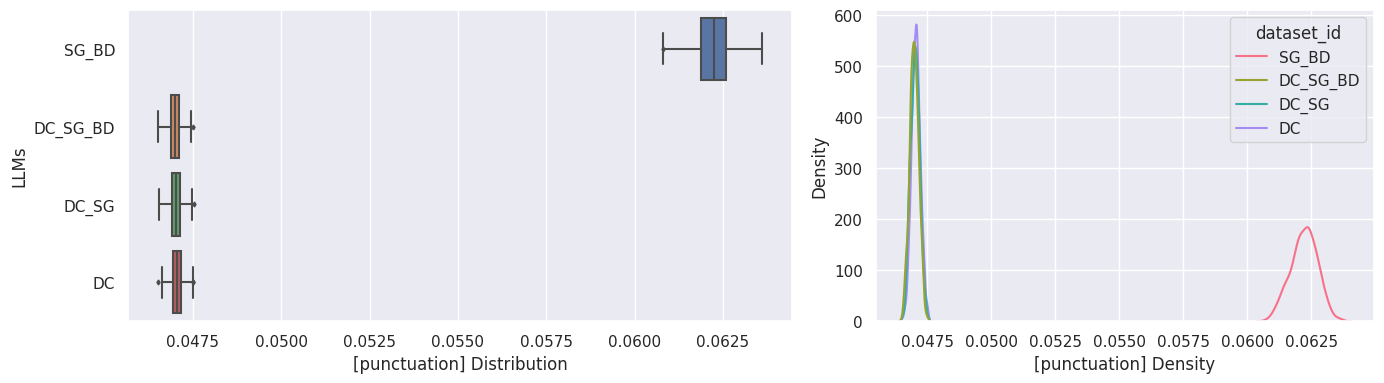

In [ ]:
f, axs = plt.subplots(1, 2, figsize=(14, 4), gridspec_kw=dict(width_ratios=[4, 3]))
g = sns.kdeplot(
    data=category_df, 
    x="rational_value", 
    hue="dataset_id",
    palette = 'husl',
    ax=axs[1]
)
h = sns.boxplot(
    data=category_df,
    x="rational_value", 
    y="dataset_id", 
    fliersize = 2.5, 
    orient="h",
    ax=axs[0]
)
h.set(xlabel=f"[{category}] Distribution", ylabel="LLMs")
g.set(xlabel=f"[{category}] Density", ylabel="Density")
    
f.tight_layout()

In [ ]:
df_rationales_distributions_level_1

,dataset_id,rational_category,rational_value
0,SG_BD,punctuation,0.062116
1,SG_BD,punctuation,0.062310
2,SG_BD,punctuation,0.062232
3,SG_BD,punctuation,0.062790
4,SG_BD,punctuation,0.062764
...,...,...,...
66495,DC,nl_particle,0.039217
66496,DC,nl_particle,0.049778
66497,DC,nl_particle,0.028319
66498,DC,nl_particle,0.068493
